In [3]:
def image_to_camera_frame(pose3d_image_frame, box, camera, rootIdx, root_depth):
    rectangle_3d_size = 2000.0
    ratio = (box[2] - box[0] + 1) / rectangle_3d_size
    pose3d_image_frame = pose3d_image_frame.copy()
    pose3d_image_frame[:, 2] = pose3d_image_frame[:, 2] / ratio + root_depth

    cx, cy, fx, fy = camera['cx'], camera['cy'], camera['fx'], camera['fy']
    pose3d_image_frame[:, 0] = (pose3d_image_frame[:, 0] - cx) / fx
    pose3d_image_frame[:, 1] = (pose3d_image_frame[:, 1] - cy) / fy
    pose3d_image_frame[:, 0] *= pose3d_image_frame[:, 2]
    pose3d_image_frame[:, 1] *= pose3d_image_frame[:, 2]
    return pose3d_image_frame

PROIEZIONE 3D -> 2D
[[478.21797756 374.0626201 ]
 [462.34271978 379.11023945]
 [462.20836299 487.37078381]
 [465.8699478  598.22564572]
 [493.85396903 369.59140189]
 [492.49315914 475.79953494]
 [498.76223598 583.81559793]
 [483.87889448 316.05187245]
 [476.6830788  253.11277516]
 [475.55592563 226.80579498]
 [477.43742075 198.5746827 ]
 [461.07773506 273.4510703 ]
 [448.25025555 342.28155576]
 [440.05122036 397.12911099]
 [493.94710734 269.2872819 ]
 [508.50015495 331.77229017]
 [509.47641494 383.27072747]]


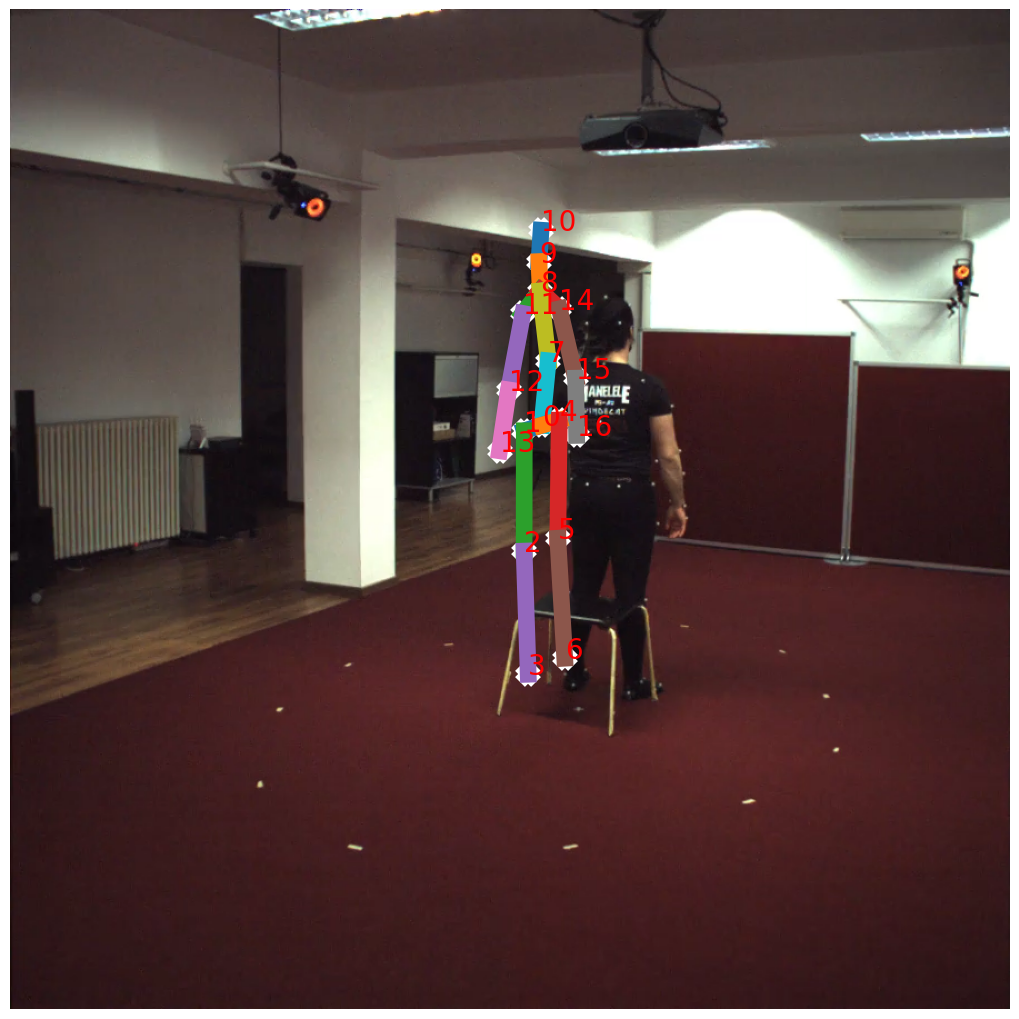

In [12]:
import sys
import numpy as np
import os

sys.path.append('..')
from util.dataset_util import project_3d_to_2d, plot_over_image, read_data, load_data_from_pickle
ROOT_PATH = os.getcwd()
data_root = os.path.join(ROOT_PATH, '..', '..', 'dataset')
#data_root = '/Users/andreaongaro/Documents/Documenti Andrea Ongaro/Magistrale/Torino/Corsi/2_ANNO/ComputerVision/Project/lcn-pose/dataset'
#data_pred_path = '/Users/andreaongaro/Documents/Documenti Andrea Ongaro/Magistrale/Torino/Corsi/2_ANNO/ComputerVision/Project/lcn-pose/experiment_good/test17/result.pkl'  # replace this with your prediction

subset = 'test' # select from ['train']
subj_name = 's01_t' # subject names for 'train' subset
action_name = '147'# action names
camera_name = '58860488' # select from ['50591643', '58860488', '60457274', '65906101']
 # path to the parent directory (contains test/ meta/)
dataset_name = 'humansc3d'
n_test = 17
data_pred_path = os.path.join(ROOT_PATH, '..', '..', 'experiment', 'test'+str(n_test), 'result.pkl')
if not os.path.exists(data_pred_path):
            raise FileNotFoundError(f"File result.pkl not found at: {data_pred_path}")


frames, j3ds, cam_params, _, _, annotations = read_data(data_root, 
                                                                            dataset_name, 
                                                                             subset, 
                                                                             subj_name, 
                                                                             action_name, 
                                                                             camera_name)

R = cam_params['extrinsics']['R']
T = cam_params['extrinsics']['T']

import os
import pickle

#DATAITEM_GT_PATH = os.path.join("/Users/andreaongaro/Documents/Documenti Andrea Ongaro/Magistrale/Torino/Corsi/2_ANNO/ComputerVision/Project/lcn-pose/dataset/humansc3d_test.pkl")
DATAITEM_GT_PATH = os.path.join(data_root, dataset_name+"_test.pkl")
dataitem_gt = []
with open(DATAITEM_GT_PATH, 'rb') as f:
    dataitem_gt = pickle.load(f)


with open(data_pred_path, 'rb') as f:
    preds = pickle.load(f)['result']  # [N, 17, 3]

preds = np.reshape(preds, (-1, 17, 3))

idx = int(action_name) - 139 # action_name starts from 139, so we subtract 139 to get the index
pred = preds[idx]  # [17, 3]
#pred = image_to_camera_frame(pose3d_image_frame=pred, box=dataitem_gt[idx]['box'],
#            camera=dataitem_gt[idx]['camera_param'], rootIdx=0,
#            root_depth=dataitem_gt[idx]['root_depth'])

#Conversione 
#j3d_in_camera = np.matmul(np.array(pred) - cam_params['extrinsics']['T'], np.transpose(cam_params['extrinsics']['R']))
#pred = j3d_in_camera

frame = frames[0]
#j2d_camera = project_3d_to_2d(j3d_in_camera, cam_params['intrinsics_w_distortion'], 'w_distortion')
j2d_camera = pred[:, :2]
print("PROIEZIONE 3D -> 2D")
print(j2d_camera)
plot_over_image(frame, j2d_camera)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

x = np.linspace(-100, 100, 100)
y = np.linspace(-100, 100, 100)
z = np.linspace(-100, 100, 100)
X, Y, Z = np.meshgrid(x, y, z)

j3d_in_camera = np.array(pred)
# Plot the 3D points
ax.scatter3D(j3d_in_camera[:,0], j3d_in_camera[:,1], j3d_in_camera[:,2], color='red')

#give the labels to each point
for x, y, z, label in zip(j3d_in_camera[:,0], j3d_in_camera[:,1], j3d_in_camera[:,2], [ str(x) for x in range(17)]):
    ax.text(x, y, z, label)
    # Link the points with lines

limbs = [[10, 9], [9, 8], [8, 11], [8, 14], [11, 12], [14, 15], [12, 13], [15, 16],
                    [8, 7], [7, 0], [0, 1], [0, 4], [1, 2], [4, 5], [2, 3], [5, 6],
                    [13, 21], [13, 22], [16, 23], [16, 24], [3, 17], [3, 18], [6, 19], [6, 20]]

num_points = j3d_in_camera.shape[0]
for limb in limbs:
    if limb[0] < num_points and limb[1] < num_points:
        #ax.plot([j3d_in_camera[limb[0], 0], j3d_in_camera[limb[1], 0]], 
        #        [j3d_in_camera[limb[0], 1], j3d_in_camera[limb[1], 1]],
        #    linewidth=12.0)
        print("S")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pose - Rilevato da noi')


plt.show()

C:\Users\anton\AppData\Local\Temp\ipykernel_39652\3243477968.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


NameError: name 'j2d_camera' is not defined

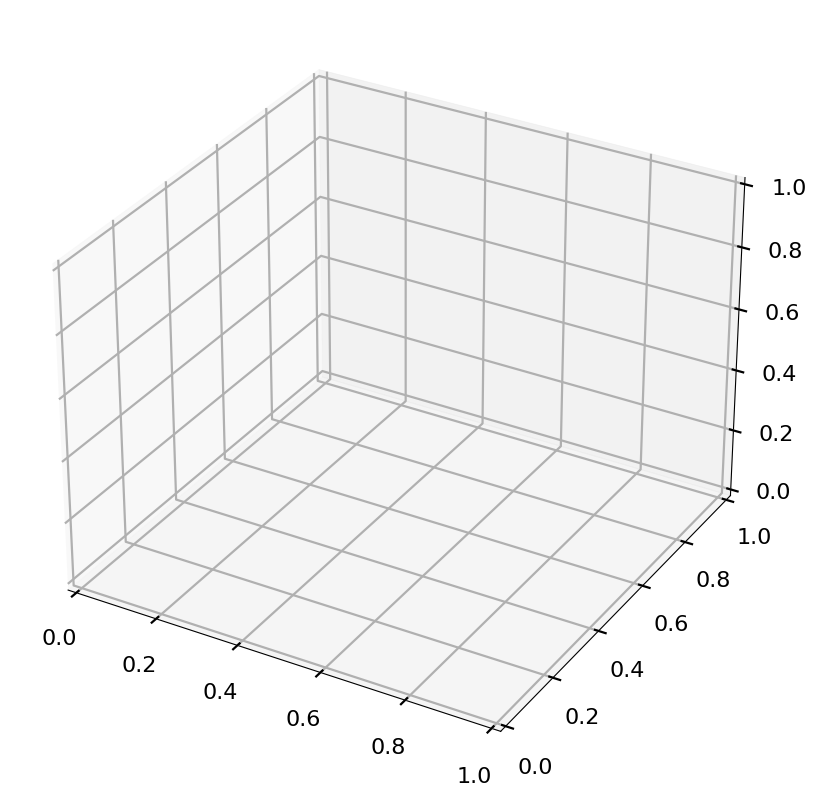

In [8]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

x = np.linspace(-100, 100, 100)
y = np.linspace(-100, 100, 100)
z = np.linspace(-100, 100, 100)
X, Y, Z = np.meshgrid(x, y, z)

limbs = [[10, 9], [9, 8], [8, 11], [8, 14], [11, 12], [14, 15], [12, 13], [15, 16],
                    [8, 7], [7, 0], [0, 1], [0, 4], [1, 2], [4, 5], [2, 3], [5, 6],
                    [13, 21], [13, 22], [16, 23], [16, 24], [3, 17], [3, 18], [6, 19], [6, 20]]

num_points = j2d_camera.shape[0]
for limb in limbs:
    if limb[0] < num_points and limb[1] < num_points:
        ax.plot([j2d_camera[limb[0], 0], j2d_camera[limb[1], 0]], 
                [j2d_camera[limb[0], 1], j2d_camera[limb[1], 1]],
            linewidth=12.0)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('2D Pose - Rilevato da noi')


plt.show()